(**Click the icon below to open this notebook in Colab**)

[![Open InColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiangshiyin/machine-learning-for-actuarial-science/blob/main/2025-spring/week08/notebook/demo.ipynb)

In [1]:
%%sh

ls -l work/2025-spring/week08/

total 4
-rw-r--r-- 1 jovyan users 476 Feb 25 03:21 README.md
drwxr-xr-x 4 jovyan users 128 Feb 26 21:58 data
drwxr-xr-x 3 jovyan users  96 Feb 25 03:19 notebook
drwxr-xr-x 2 jovyan users  64 Feb 25 03:19 pics


# Recap of Last Class

## Example - `prophet`

Prophet is an enhanced statistical tool because it extends traditional time series models with automated trend and seasonality detection, making it user-friendly and effective for business applications.

## Key Differences Between Holiday Effect and Seasonality  

| Feature            | Seasonality  | Holiday Effect |
|--------------------|-------------|---------------|
| **Definition**     | A **repeating pattern** that occurs at a fixed frequency (e.g., daily, weekly, yearly). | An impact on the time series caused by specific holidays or events. |
| **Regularity**     | **Strictly periodic** (e.g., weekly sales cycles, annual weather patterns). | **Not necessarily periodic** (holidays can fall on different weekdays each year). |
| **Examples**       | Increased ice cream sales in summer (yearly seasonality). Higher website traffic on weekends (weekly seasonality). | Lower stock market activity on Christmas. Higher online sales on Black Friday. |
| **Modeling in Prophet** | Modeled using a **Fourier series** to capture repeating cycles. | Modeled using **dummy variables** for specific dates, allowing deviations from normal patterns. |


In [2]:
import pandas as pd
from prophet import Prophet

playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

Importing plotly failed. Interactive plots will not work.


In [3]:
holidays

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


The time series of the log daily page views for the Wikipedia page for Peyton Manning is used here
- https://facebook.github.io/prophet/docs/quick_start.html

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [5]:
m = Prophet(holidays=holidays)
m.fit(df)

future = m.make_future_dataframe(periods=365)
future.tail()

18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:10 - cmdstanpy - INFO - Chain [1] done processing


,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [6]:
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.217847,1.200633
2191,2014-02-03,1.898839,1.455819
2532,2015-01-11,1.217847,0.000000
2533,2015-01-12,1.898839,0.000000
2901,2016-01-17,1.217847,0.000000
2902,2016-01-18,1.898839,0.000000
2908,2016-01-24,1.217847,0.000000
2909,2016-01-25,1.898839,0.000000
2922,2016-02-07,1.217847,1.200633
2923,2016-02-08,1.898839,1.455819


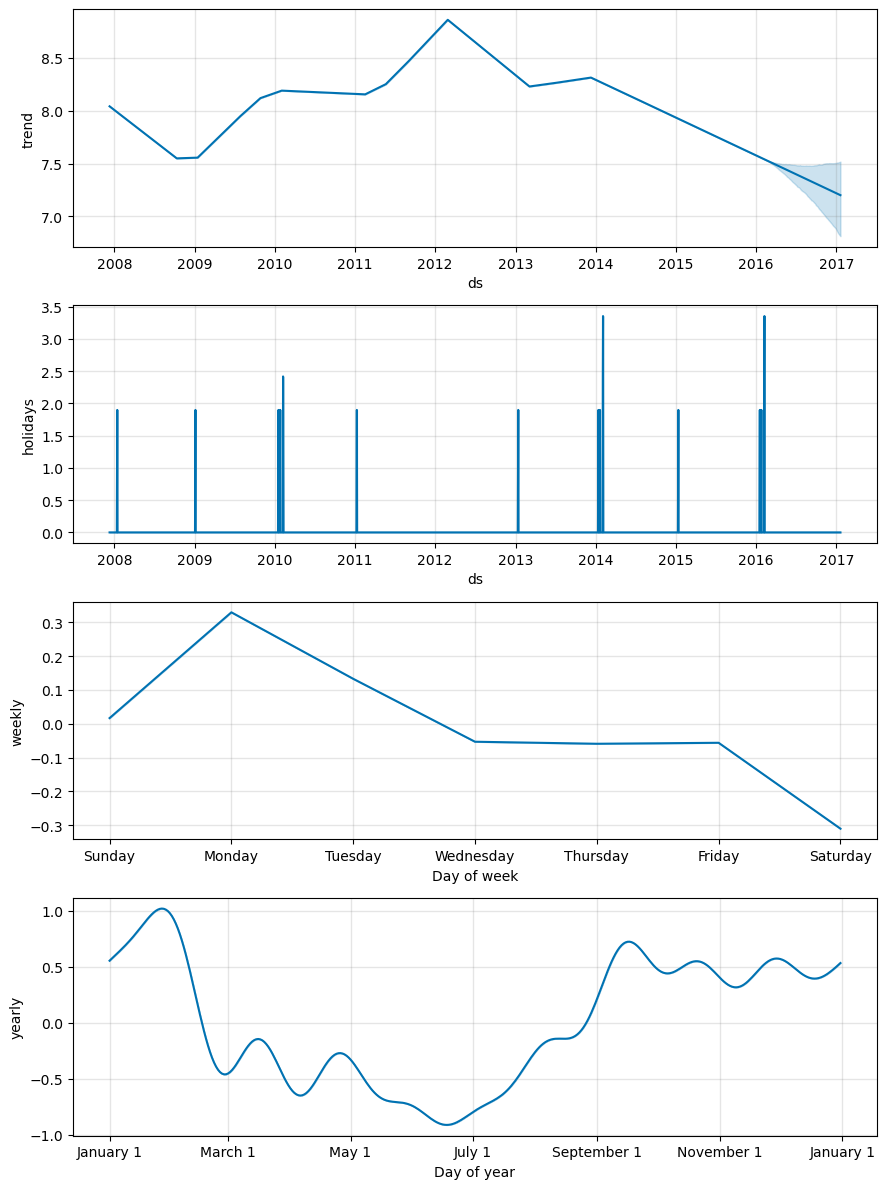

In [7]:
fig = m.plot_components(forecast)

## Example - `LSTM`

### Train the LSTM model

In [8]:
import matplotlib.pyplot as plt
import yfinance as yf

stock_symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2025-01-31'

# Download historical data
df_aapl = yf.download(stock_symbol, start=start_date, end=end_date).Close.reset_index()
df_aapl.set_index('Date', inplace=True)
df_aapl.columns = ['Close']
df_aapl.head(10)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Close
Date,
2020-01-02,72.716080
2020-01-03,72.009109
2020-01-06,72.582916
2020-01-07,72.241570
2020-01-08,73.403633
2020-01-09,74.962799
2020-01-10,75.132256
2020-01-13,76.737427
2020-01-14,75.701218


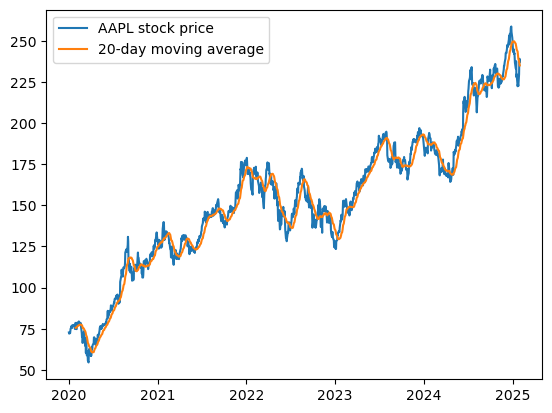

In [9]:
plt.plot(df_aapl.Close, label='AAPL stock price')
plt.plot(df_aapl.Close.rolling(20).mean(), label='20-day moving average')
plt.legend()
plt.show()

In [10]:
dataset_train = df_aapl.loc[:"2024-12-31", :].copy()
dataset_train.tail(3)

,Close
Date,
2024-12-27,255.309296
2024-12-30,251.923019
2024-12-31,250.144974


In [11]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set = dataset_train.Close.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [12]:
import numpy as np

X_train = []
y_train = []

for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

2025-03-01 18:44:13.941320: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - loss: 0.0849
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 0.0129
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - loss: 0.0068
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 0.0051
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0045
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.0038
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 0.0044
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - loss: 0.0041
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0038
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0042
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - loss: 0.0040
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 0.0044
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 0.0044
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.0034
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [16]:
import tensorflow as tf

tf.__version__

'2.18.0'

### Prediction

In [17]:
dataset_train.tail(3)

,Close
Date,
2024-12-27,255.309296
2024-12-30,251.923019
2024-12-31,250.144974


In [18]:
dataset_test = df_aapl.loc["2025-01-01":, :].copy()
pred_inputs = pd.concat(
    [
        dataset_train.iloc[-60:,:],
        dataset_test,
    ],
    axis=0
)
pred_inputs = pred_inputs.Close.values.reshape(-1, 1)
pred_inputs[:3]

array([[221.20315552],
       [225.27420044],
       [229.03591919]])

In [19]:
pred_inputs = sc.transform(pred_inputs)
X_test = []
for i in range(60, 80):
    X_test.append(pred_inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


In [20]:
dataset_test.shape

(19, 1)

In [21]:
predicted_stock_price = pd.DataFrame(predicted_stock_price[:19], index=dataset_test.index[:19], columns=['Close'])
predicted_stock_price.head(3)

,Close
Date,
2025-01-02,258.461700
2025-01-03,257.422607
2025-01-06,255.245682


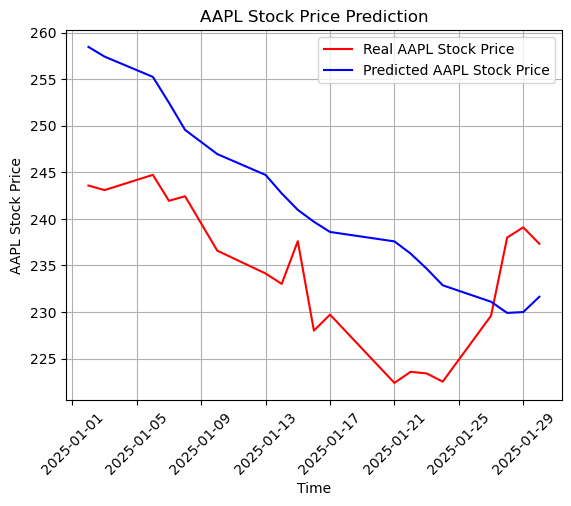

In [22]:
plt.plot(dataset_test[:19], color = 'red', label = 'Real AAPL Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()